In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
from matplotlib import pylab as plt

# Step A: define the physical model

In [2]:
model = ot.SymbolicFunction(["F", "E", "L", "I"], ["F*L^3/(3*E*I)"])
model = ot.MemoizeFunction(model)
model.enableCache()

# Step B: specify the input random vector # 

In [3]:
sample_E = ot.Sample.ImportFromCSVFile("sample_E.csv")
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(["Young modulus"])

In [4]:
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000, 9000, 15000]))
F.setDescription(["Load"])

In [5]:
L = ot.Uniform(250, 260)
L.setDescription(["Length"])

In [6]:
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(["Inertia"])

In [7]:
marginal_distributions = [F, E, L, I]

In [8]:
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

In [9]:
input_distribution = ot.ComposedDistribution(marginal_distributions, copula)
dimension = input_distribution.getDimension()

In [10]:
input_random_vector = ot.RandomVector(input_distribution)

# Step C: uncertainty propagation

A kriging metamodel is used.

## Specification of the basis

We can use existing basis factory : ConstantBasisFactory, LinearBasisFactory, QuadraticBasisFactory, or create our own basis using a collection of NumericalMathFunction and transform it into a basis.

In [11]:
basis = ot.ConstantBasisFactory(dimension).build()
print(basis)

Basis( [class=LinearEvaluation name=Unnamed center=[0,0,0,0] constant=[1] linear=[[ 0 ]
 [ 0 ]
 [ 0 ]
 [ 0 ]]] )


## Choice of the Design of Experiment

We can choose a Monte Carlo DOE or a more space filling DOE.

In [12]:
design_of_experiments = ot.MonteCarloExperiment(input_distribution, 100)
input_sample = design_of_experiments.generate()
output_sample = model(input_sample)

In [13]:
# normalization if needed: linear transformation
mean = input_sample.computeMean()
stddev = input_sample.computeStandardDeviationPerComponent()
linear = ot.SquareMatrix(dimension)

for j in range(dimension):
    linear[j, j] = 1.0 / stddev[j] if abs(stddev[j]) > 1e-12 else 1.0
zero = [0.0] * dimension

transformation = ot.LinearFunction(mean, zero, linear)

normalized_inputSample = transformation(input_sample)

## Specification of the covariance model

The covariance model can be a model of dimension corresponding of the input dimension. Or it can be a product covariance model where each input has its own covariance mode of dimension 1. If the output dimension is greater than 1, the user can provide a tensorized covariance model.

In [14]:
# we create a product covariance model where each input has its own covariance model
covColl = ot.CovarianceModelCollection(dimension)
for i in range(dimension):
    covColl[i] = ot.SquaredExponential([1])
covarianceModel = ot.ProductCovarianceModel(covColl)

In [15]:
covarianceModel.setScale(input_sample.getMax())  # Trick A
covarianceModel.getScale()

class=Point name=Unnamed dimension=4 values=[83949.1,4.52164e+07,259.83,433.689]

## Running the kriging algorithm

In [16]:
kriging_algorithm = ot.KrigingAlgorithm(
    input_sample, output_sample, covarianceModel, basis
)
# set the global optimization algorithm to improve the optimization result
kriging_algorithm.setOptimizationAlgorithm(ot.NLopt("GN_DIRECT"))
scaleOptimizationBounds = ot.Interval(input_sample.getMin(), input_sample.getMax())
kriging_algorithm.setOptimizationBounds(scaleOptimizationBounds)  # Trick B
kriging_algorithm.run()

In [17]:
kriging_result = kriging_algorithm.getResult()
metamodel = kriging_result.getMetaModel()
covarianceModel = kriging_result.getCovarianceModel()
print(
    "Covariance model parameters : {}".format(
        kriging_result.getCovarianceModel().getScale()
    )
)
print(
    "Covariance model amplitude : {}".format(
        kriging_result.getCovarianceModel().getAmplitude()
    )
)

Covariance model parameters : [83544.3,3.22669e+07,250.236,413.599]
Covariance model amplitude : [88.9545]


## Assess the metamodel goodness-of-fit

In [18]:
def computeLOO(inputSample, outputSample, krigingResult):
    """
    Compute the Leave One out prediction analytically (from Dubrule 1983 paper).
    """
    inputSample = np.array(inputSample)
    outputSample = np.array(outputSample)

    # get covariance model
    cov = krigingResult.getCovarianceModel()
    # get coefficient and compute trend
    basis = krigingResult.getBasisCollection()[0]
    F1 = krigingResult.getTrendCoefficients()[0]
    size = inputSample.shape[0]
    p = F1.getDimension()
    F = np.ones((size, p))
    for i in range(p):
        F[:, i] = np.hstack(basis.build(i)(normalized_inputSample))
    # Calcul de y_loo
    K = np.array(cov.discretize(normalized_inputSample))
    Z = np.zeros((p, p))
    S = np.vstack([np.hstack([K, F]), np.hstack([F.T, Z])])
    S_inv = np.linalg.inv(S)
    B = S_inv[:size:, :size:]
    B_but_its_diag = B * (np.ones(B.shape) - np.eye(size))
    B_diag = np.atleast_2d(np.diag(B)).T
    y_loo = (-np.dot(B_but_its_diag / B_diag, outputSample)).ravel()
    return ot.Sample(np.vstack(y_loo))

In [19]:
def computeQ2(inputSample, outputSample, krigingResult):
    """
    Compute the Q2 using the analytical loo prediction.
    """
    y_loo = np.hstack(computeLOO(inputSample, outputSample, krigingResult))
    # Calcul du Q2
    delta = np.hstack(outputSample) - y_loo
    Q2 = 1 - np.mean(delta ** 2) / np.var(outputSample)
    return Q2

As kriging is an interpolating technique, R2 value is 1 so it does not provide good information about the kriging model quality. It is more relevant to compute the Q2 using the leave-one out prediction.

In [20]:
validation = ot.MetaModelValidation(input_sample, output_sample, metamodel)
print("R2 : ", validation.computePredictivityFactor())
print("Q2 : ", computeQ2(input_sample, output_sample, kriging_result))

R2 :  [1]
Q2 :  0.9478282544265058


### Adequation plot on leave-one out predictions

/home/devel/miniconda3/envs/othpcuqtraining/lib/python3.8/site-packages/openturns/viewer.py:558: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._fig.show(**kwargs)


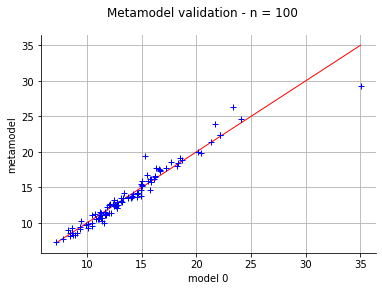

In [21]:
output_LOO = computeLOO(input_sample, output_sample, kriging_result)
validation = ot.MetaModelValidation(input_sample, output_LOO, metamodel)
View(validation.drawValidation()).show()

### Superposition of the model and the metamodel in 1D cuts

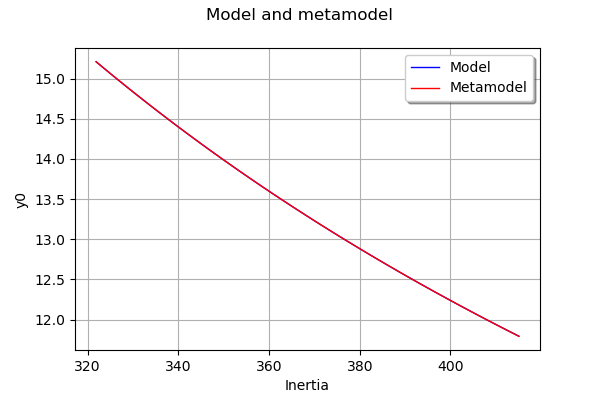

In [22]:
input_number = 3
input_margin = input_distribution.getMarginal(input_number)
model_cut = model.draw(
    input_number,
    0,
    input_distribution.getMean(),
    input_margin.computeQuantile(0.025)[0],
    input_margin.computeQuantile(0.975)[0],
    100,
).getDrawable(0)
metamodel_cut = metamodel.draw(
    input_number,
    0,
    input_distribution.getMean(),
    input_margin.computeQuantile(0.025)[0],
    input_margin.computeQuantile(0.975)[0],
    100,
).getDrawable(0)

graph = ot.Graph("Model and metamodel", "", "", True)
graph.add([model_cut, metamodel_cut])
graph.setColors(["blue", "red"])
graph.setLegends(["Model", "Metamodel"])
graph.setXTitle(input_margin.getDescription()[0])
graph.setYTitle(model.getOutputDescription()[0])
graph.setLegendPosition("topright")
graph

### Reliability analysis using a (large) Monte Carlo sample of the kriging approximation

In [23]:
krigingRandomVector = ot.CompositeRandomVector(
    metamodel, ot.RandomVector(input_distribution)
)
event = ot.ThresholdEvent(krigingRandomVector, ot.Greater(), 30.0)
event.setName("Deviation > %s cm" % event.getThreshold())

### PDF and CDF approximations

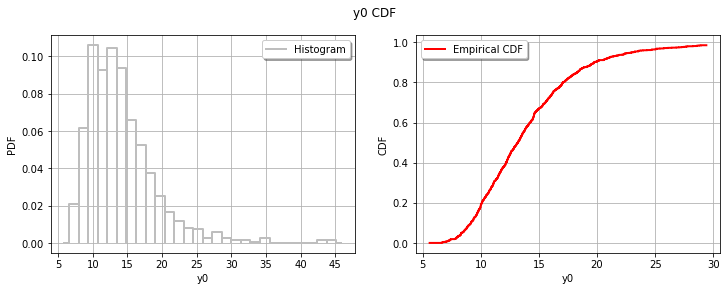

In [24]:
sample = krigingRandomVector.getSample(1000)
fig = plt.figure(figsize=(12, 4))
ax_pdf = fig.add_subplot(1, 2, 1)
hist_E = ot.HistogramFactory().build(sample).drawPDF()
hist_E.setColors(["gray"])
hist_E.setLegends(["Histogram"])
_ = View(hist_E, figure=fig, axes=[ax_pdf])
ax_cdf = fig.add_subplot(1, 2, 2)
ecdf_E = ot.UserDefined(sample).drawCDF()
ecdf_E.setLegends(["Empirical CDF"])
_ = View(ecdf_E, figure=fig, axes=[ax_cdf])

In [25]:
experiment = ot.MonteCarloExperiment()
MCS_algorithm = ot.ProbabilitySimulationAlgorithm(event, experiment)
MCS_algorithm.setMaximumOuterSampling(1000)  # Increase to 10000 to get accurate results
MCS_algorithm.setBlockSize(1)
MCS_algorithm.setMaximumCoefficientOfVariation(0.1)
MCS_algorithm.run()
MCS_result = MCS_algorithm.getResult()

In [26]:
print("Proability estimate = %.2e" % MCS_result.getProbabilityEstimate())
print("Coefficient of variation = %.2f" % MCS_result.getCoefficientOfVariation())
print(
    "95%% Confidence Interval = [%.2e, %.2e]"
    % (
        MCS_result.getProbabilityEstimate()
        - 0.5 * MCS_result.getConfidenceLength(0.95),
        MCS_result.getProbabilityEstimate()
        + 0.5 * MCS_result.getConfidenceLength(0.95),
    )
)

Proability estimate = 8.00e-03
Coefficient of variation = 0.35
95% Confidence Interval = [2.48e-03, 1.35e-02]


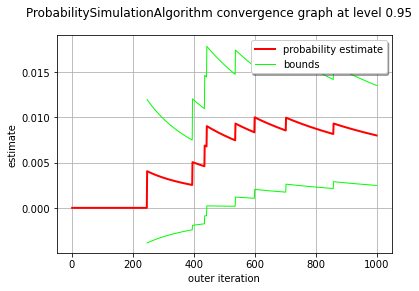

In [27]:
_ = View(MCS_algorithm.drawProbabilityConvergence(0.95))